This notebook shows how to design a transmon pocket (single pad design) in qiskit metal. The notebook only need **TransmonPocket_Single** function from a relative path '../../resources'.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
#This imports the necessary path to draw the single pad transmon design. 
import sys
sys.path.append('Customized_Components')
from rounded_single_pad import Round_TransmonPocket_Single as transmon
import Transmon_property as trans_p
import Transmon_specifications as jj

import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
import os
import shutil
import time

In [4]:
import numpy as np
import astropy.units as u
import astropy.constants as c

import pandas as pd
import matplotlib.pyplot as plt

# %matplotlib inline

In [5]:
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings

from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee
# from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
# from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond

from qiskit_metal.qlibrary.tlines.mixed_path import RouteMixed
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight

from qiskit_metal.analyses.quantization import LOManalysis
from qiskit_metal.analyses.quantization import EPRanalysis

# from qiskit_metal.toolbox_metal.parsing import *

In [6]:
# from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
# from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround


In [7]:
# pd.read_csv("Frequencies from metal pad size.csv",).plot(x= 'Pad_len (mm)', y = 'EPR Frequency (GHz)')
# plt.ylabel('Frequency (GHz)')
# plt.show()

The target frequency is around 4.2GHz. To get this frequency, we need the pad size to be around 0.275mm.

## Global variables

In [8]:
phi0 = c.h/2/c.e.si
T = 30*u.mK
epsilon_r = 11.45

In [9]:
design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '20 mm'
design.chips.main.size['size_y'] = '10 mm'

design.variables['cpw_width'] = '15 um'
design.variables['cpw_gap'] = '9 um'

design.variables['trace_width'] = '12.4 um'
cpw_pin_width = 12.4*u.um
design.variables['trace_gap'] = '7 um'
cpw_gap = 7*u.um

design.variables['pad_buffer_radius'] = '30 um'
design.variables['buffer_resolution'] = '10'
design.variables['connection_pad_buffer_radius'] = '2 um'
# design.chips['main']['material'] = 'Silicon'

gui = MetalGUI(design)

Component-specific variables

In [10]:
qb_options = dict(
pad_pocket_distance_top = '40um',
connection_pads = dict(
    a = dict(loc_W  = 0, 
            loc_H =  1, 
            pad_gap = '15um',
            pad_height = '15um',
            pad_width = '80um',
            pad_cpw_extent =  '10um',
            pocket_rise = '0um',
            cpw_extend = '0um',
            pocket_extent = '0um',)))

TQ_options = dict(prime_width = design.variables['cpw_width'],
               prime_gap = design.variables['cpw_gap'],
               second_width = design.variables['trace_width'],
               second_gap = design.variables['trace_gap'],
               down_length = '60um',
               coupling_space = '5um',
               open_termination=False,
               hfss_wire_bonds = False,
               q3d_wire_bonds = False)

CPW_options = Dict(trace_width = design.variables['trace_width'],
               trace_gap  = design.variables['trace_gap'],
        total_length='5 mm',
        hfss_wire_bonds = True,
        q3d_wire_bonds = True,
        fillet='30 um',
        lead = dict(start_straight='20um', end_straight = '50um'),
        pin_inputs=Dict(
            start_pin=Dict(component='Q1', pin='a'),
            end_pin=Dict(component='TQ1', pin='second_end')), )

pin_inputs = Dict(
            start_pin=Dict(component='Q1', pin='a'),
            end_pin=Dict(component='TQ1', pin='second_end'))

trans_options = Dict(hfss_wire_bonds = True,
                     q3d_wirebonds = True,
               pin_inputs=Dict(
                 start_pin=Dict(
                     component='TQ1',
                     pin='prime_start'),
                 end_pin=Dict(
                     component='TQ2',
                     pin='prime_end')))


## Design

Single pad transmon

In [11]:
design.delete_all_components()

In [12]:
design.overwrite_enabled = True

size = 0.25*u.mm
gap = 30*u.um
size = size.to(u.um)
pocket_width = size+2*gap


op = Dict(
    pos_x = '0',
    pad_height = '{}um'.format(size.value),
    pos_y = '0',
    pad_width = '{}'.format(size),
    pocket_width = '{}'.format(pocket_width), 
    **qb_options)

q1 = transmon(design,'Q1',options = op)

gui.rebuild()
gui.zoom_on_components(['Q1'])


In [13]:
op = Dict(
    pos_x = '1mm',
    pad_height = '{}um'.format(size.value),
    pos_y = '0',
    pad_width = '{}'.format(size),
    pocket_width = '{}'.format(pocket_width), 
    **qb_options)

q2 = transmon(design,'Q2',options = op)

gui.rebuild()
gui.zoom_on_components(['Q2'])

Coupled Line Tee

In [14]:
TQ_options['down_length'] = '40 um'
TQ1 = CoupledLineTee(design, 'TQ1', options=dict(pos_x='-0.1 mm',
                                             pos_y='0.5 mm',
                                             mirror = True,
                                             coupling_length='120 um', **TQ_options))
TQ1.options['open_termination'] = False

gui.rebuild()
gui.autoscale()

In [15]:
TQ2 = CoupledLineTee(design, 'TQ2', options=dict(pos_x='0.9 mm',
                                             pos_y='0.5 mm',
                                             mirror = True,
                                             coupling_length='120 um', **TQ_options))
TQ2.options['open_termination'] = False

gui.rebuild()
gui.autoscale()

Function that constructs CPW

In [43]:
trans_options['pin_inputs']['start_pin']['component'] = 'TQ1'
trans_options['pin_inputs']['start_pin']['pin'] = 'prime_end'
trans_options['pin_inputs']['end_pin']['component'] = 'TQ2'
trans_options['pin_inputs']['end_pin']['pin'] = 'prime_start'
middle = RouteStraight(design, 'cpw_mid', trans_options)

In [17]:
guess_path = 'data\educated_guess_0403.csv'

In [18]:
def slice_data(data, freq):
    diff = freq-4
    ind = round(diff/0.2)
    return data.iloc[ind]

# def qb_cpw_construction(q, TQ, freq, guesses = guesses):
    

In [26]:
def construct_cpw_qubit(q, TQ, freq, displacement = '0um', guess_path = guess_path,sim = True):
    guess_all = pd.read_csv(guess_path)
    guesses = slice_data(guess_all, freq)
    size = guesses['Sizes (um)']*u.um
    buffer = guesses['Buffers (um)']*u.um
    offset = guesses['Offsets (mm)']
    coupling_len = guesses['Coupling_len(um)']*u.um
    coupling_gap = guesses['Coupling_gap(um)']*u.um
    Lj = guesses['Ljs']
    Cj = jj.find_junction_capacitance(int(Lj[:-2])*u.nH)
    
    Cj1 = str(Cj.to(u.fF).value)+' fF'
    size = size.to(u.um)

    TQx = guesses['TQx']
    TQy = guesses['TQy']
    TQ_mir = guesses['TQ_mir']
    small = guesses['Small']
    
    q, cpw, TQ = Construct_CPW(q, TQ, size, offset, coupling_len, coupling_gap, Lj, Cj1, TQx,TQy, small, TQ_mir,displacement, buffer, sim)
    return q,cpw, TQ

In [27]:
def Construct_CPW(q, TQ, pad_size, offset, extend, gapp, Lj, Cj, TQx,TQy, small, TQ_mir, displacement = '0um', buffer = 150*u.um, sim  = True):
    gap1 = 0.056
    gap = 30*u.um
    size = pad_size.to(u.um)
    pocket_width = size+2*gap
    cpw_name = 'cpw_'+ q.name[-1:]
    design.delete_component(cpw_name)
    coupling_len = extend
    q.options['pad_height'] = '{}'.format(size)
    q.options['pad_width'] = '{}'.format(size)
    q.options['pocket_width'] = '{}'.format(pocket_width)
    q.options['connection_pads']['a']['pad_width'] = '{}'.format(coupling_len)
    q.options['connection_pads']['a']['pad_height'] = '30um-{}'.format(gapp)
    q.options['connection_pads']['a']['pad_gap'] = '{}'.format(gapp)
    q.options.hfss_inductance = Lj
    q.options.q3d_inductance =  Lj
    q.options.hfss_capacitance = Cj
    q.options.q3d_capacitance =  Cj

    l_name = 'Lj'+ q.name[-1:]
    c_name = 'Cj'+ q.name[-1:]

    if sim:
        eig_all.sim.renderer.options[l_name] = Lj
        eig_all.sim.renderer.options[c_name] = Cj
        eig_all.sim.setup.vars = {l_name:Lj, c_name:Cj}
    
    gui.rebuild()

    TQ.options.pos_x = TQx + '+' + displacement
    q.options.pos_x = displacement
    q.options.pos_y = '-'+TQy
    TQ.options.mirror = TQ_mir
    TQ.options.pos_y = '0um'
    gui.rebuild()

    anchors = trans_p.anchor_CPW_round(q, buffer, gap1, 2, small = small, last_offset = offset)
    design.delete_component(cpw_name)
    gui.rebuild()
    
    pin_inputs = Dict(
                start_pin=Dict(component=q.name, pin='a'),
                end_pin=Dict(component=TQ.name, pin='second_end'))

    CPW_options['pin_inputs'] = pin_inputs

    qa = RouteMixed(design, 'cpw_'+q.name[-1:], options = Dict(anchors = anchors, **CPW_options))

    gui.rebuild()
    
    return q, qa, TQ

    
    # length = trans_p.find_total_len(qa, q1, TQ1, count_extend=False)
    # return (trans_p.find_actual_frequency(length, cpw_pin_width, cpw_gap), length)

In [28]:
construct_cpw_qubit(q1, TQ1, 5, displacement = '0um', guess_path = guess_path, sim = False)

06:14PM 12s INFO [delete_component]: Called delete_component cpw_1, but such a component is not in the design cache dictionary of components.


(name:    Q1
 class:   Round_TransmonPocket_Single
 options: 
   'pos_x'             : '0um',                        
   'pos_y'             : '-0.5mm',                     
   'orientation'       : '0.0',                        
   'chip'              : 'main',                       
   'layer'             : '1',                          
   'connection_pads'   : {
        'a'                 : {
             'pad_gap'           : '15.0 um',                    
             'pad_width'         : '30.0 um',                    
             'pad_height'        : '30um-15.0 um',               
             'pad_cpw_shift'     : '5um',                        
             'pad_cpw_extent'    : '10um',                       
             'cpw_width'         : 'trace_width',                
             'cpw_gap'           : 'trace_gap',                  
             'round_corners'     : 'True',                       
             'corner_radius'     : 'connection_pad_buffer_radius',
    

In [29]:
construct_cpw_qubit(q2, TQ2, 4.4, displacement = '1mm', guess_path = guess_path, sim = False)

06:14PM 15s INFO [delete_component]: Called delete_component cpw_2, but such a component is not in the design cache dictionary of components.
06:14PM 16s INFO [delete_component]: Called delete_component cpw_2, but such a component is not in the design cache dictionary of components.


(name:    Q2
 class:   Round_TransmonPocket_Single
 options: 
   'pos_x'             : '1mm',                        
   'pos_y'             : '-0.5mm',                     
   'orientation'       : '0.0',                        
   'chip'              : 'main',                       
   'layer'             : '1',                          
   'connection_pads'   : {
        'a'                 : {
             'pad_gap'           : '15.0 um',                    
             'pad_width'         : '22.0 um',                    
             'pad_height'        : '30um-15.0 um',               
             'pad_cpw_shift'     : '5um',                        
             'pad_cpw_extent'    : '10um',                       
             'cpw_width'         : 'trace_width',                
             'cpw_gap'           : 'trace_gap',                  
             'round_corners'     : 'True',                       
             'corner_radius'     : 'connection_pad_buffer_radius',
    

# Simulation

Import Qiskit Packages

In [30]:
from qiskit_metal.analyses.quantization import LOManalysis
from qiskit_metal.analyses.quantization import EPRanalysis

Set the right path for Ansys Screenshots

In [31]:
original = r'C:\Users\slab\Desktop\Wendy-qiskit-code\ansys.png'
path = r'C:\Users\slab\Desktop\Wendy-qiskit-code\Ansys_screenshoots\Simulation_0404'

In [32]:
components  = ['Q1','cpw_1','TQ1','Q2','TQ2','cpw_2','cpw_mid']
nmode = 4
datas = pd.DataFrame()

In [33]:
renderer_hfss = design.renderers.hfss
renderer_q3d = design.renderers.q3d

In [34]:
c1 = LOManalysis(design, "q3d")
c1.sim.setup.min_passes  = 10
c1.sim.setup.max_passes = 20
c1.sim.setup.freq_ghz = 5

c1.sim.renderer.options['wb_threshold'] ='72um'
c1.sim.renderer.options['x_buffer_width_mm'] = 0.5
c1.sim.renderer.options['y_buffer_width_mm'] = 0.5

In [35]:
eig_all = EPRanalysis(design, 'hfss')

hfss = eig_all.sim.renderer
eig_all.sim.renderer.options['wb_threshold'] = '72um'

eig_all.sim.setup.max_passes = 30
eig_all.sim.setup.max_delta_f = 0.1
eig_all.sim.setup.n_modes = nmode
eig_all.sim.setup.vars = Dict(Lj1= '13 nH', Cj1= '0 fF')
eig_all.sim.renderer.options['x_buffer_width_mm'] = 0.5
eig_all.sim.renderer.options['y_buffer_width_mm'] = 0.5


In [36]:
components_all = ['Q1','Q2','cpw_1','cpw_2','TQ1','TQ2','CPW_left','CPW_right', 'CPW_mid','wb_left','wb_right']

In [37]:
all_freqs = np.arange(4,6,0.2)

In [49]:
all_freqs

array([4. , 4.2, 4.4, 4.6, 4.8, 5. , 5.2, 5.4, 5.6, 5.8])

In [75]:
for x,y in p:#combinations(range(10),2):
    print(x,y)

In [74]:
i

(5.600000000000001, 5.800000000000002)

In [69]:
from itertools import combinations
p = combinations(all_freqs,2)

In [53]:
p

start

06:18PM 11s INFO [delete_component]: Called delete_component cpw_1, but such a component is not in the design cache dictionary of components.
06:18PM 13s INFO [delete_component]: Called delete_component cpw_2, but such a component is not in the design cache dictionary of components.
INFO 06:18PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 06:18PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 06:18PM [analyze]: Analyzing setup Setup
INFO 06:21PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpvsv5lx9x.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 06:21PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpghim84o4.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 06:21PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpdi_

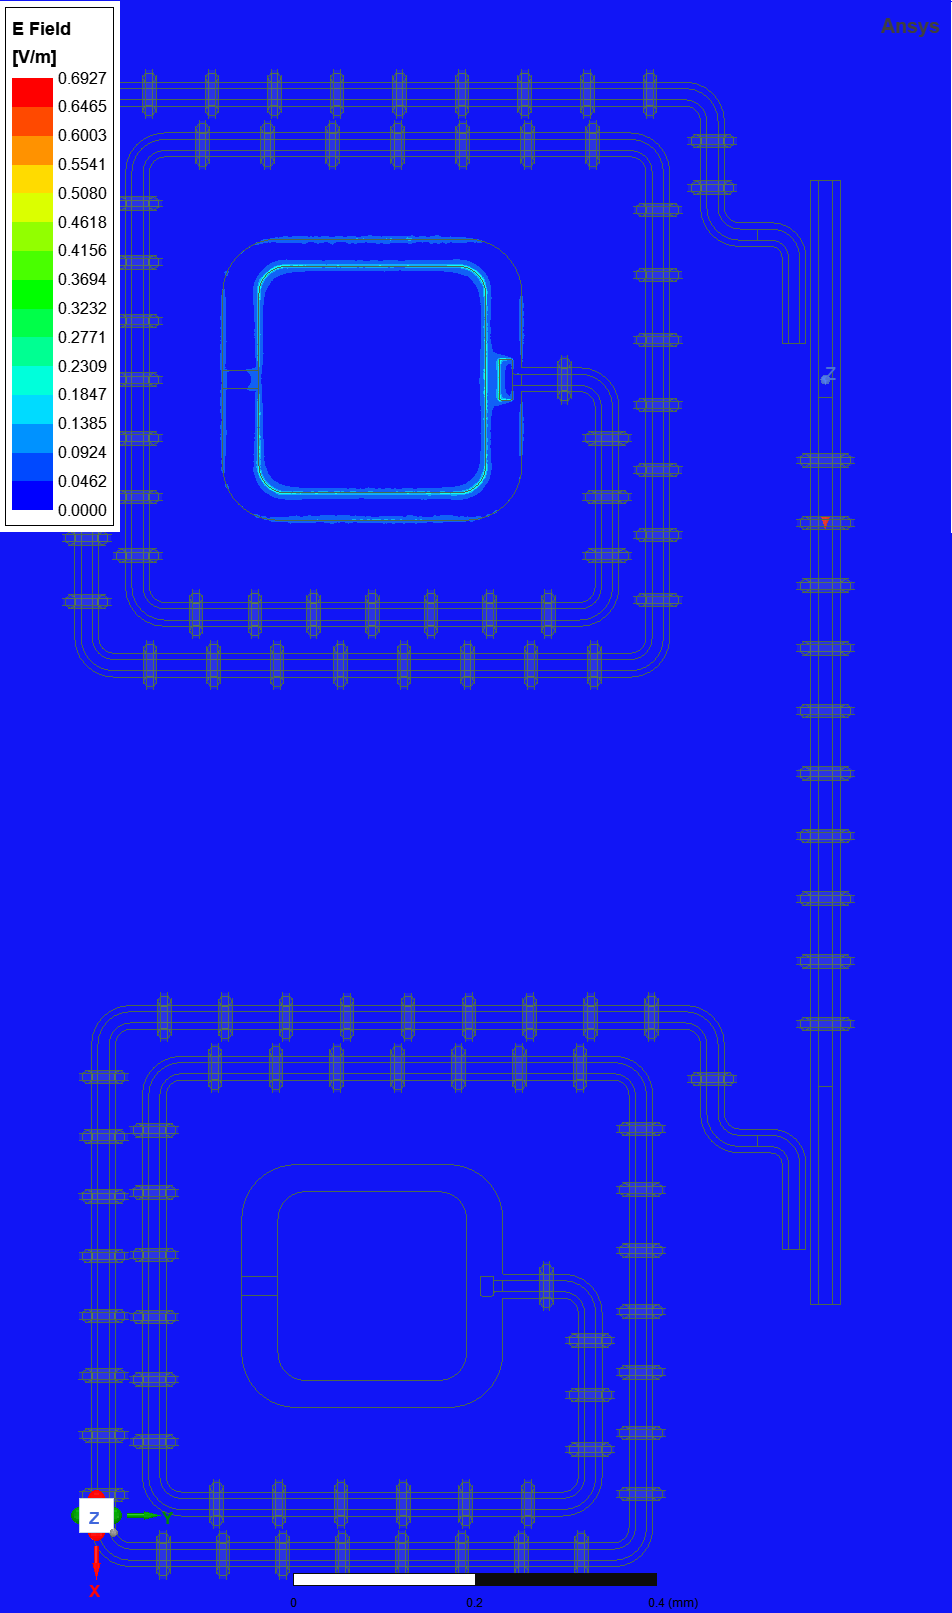

INFO 08:09PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
08:09PM 22s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


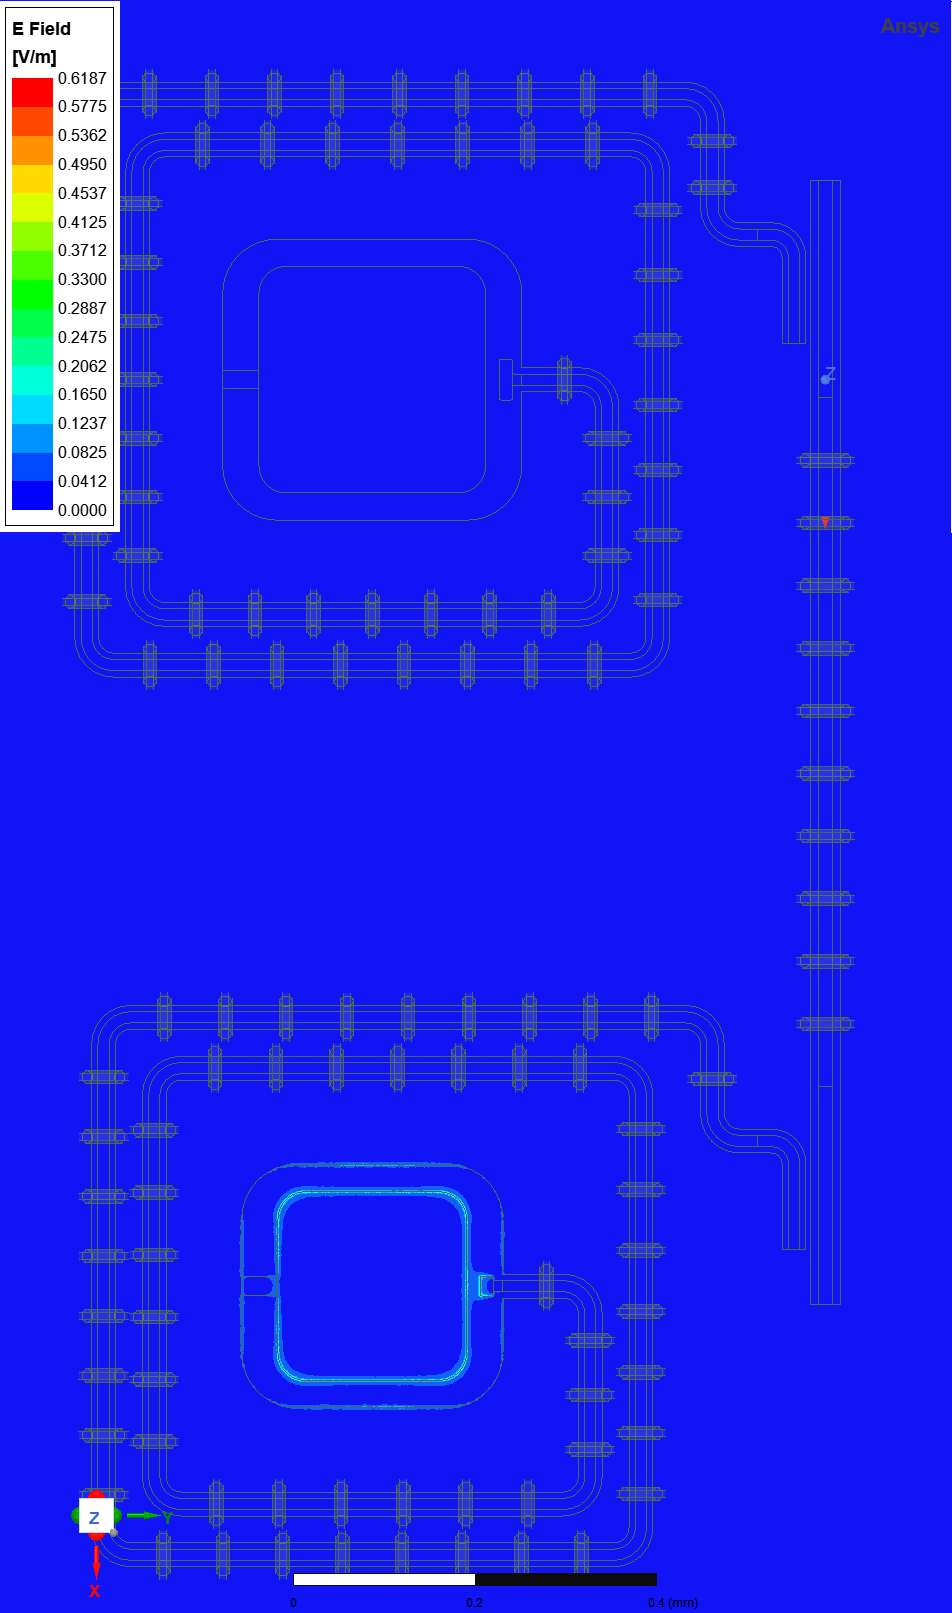

INFO 08:09PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
08:09PM 42s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


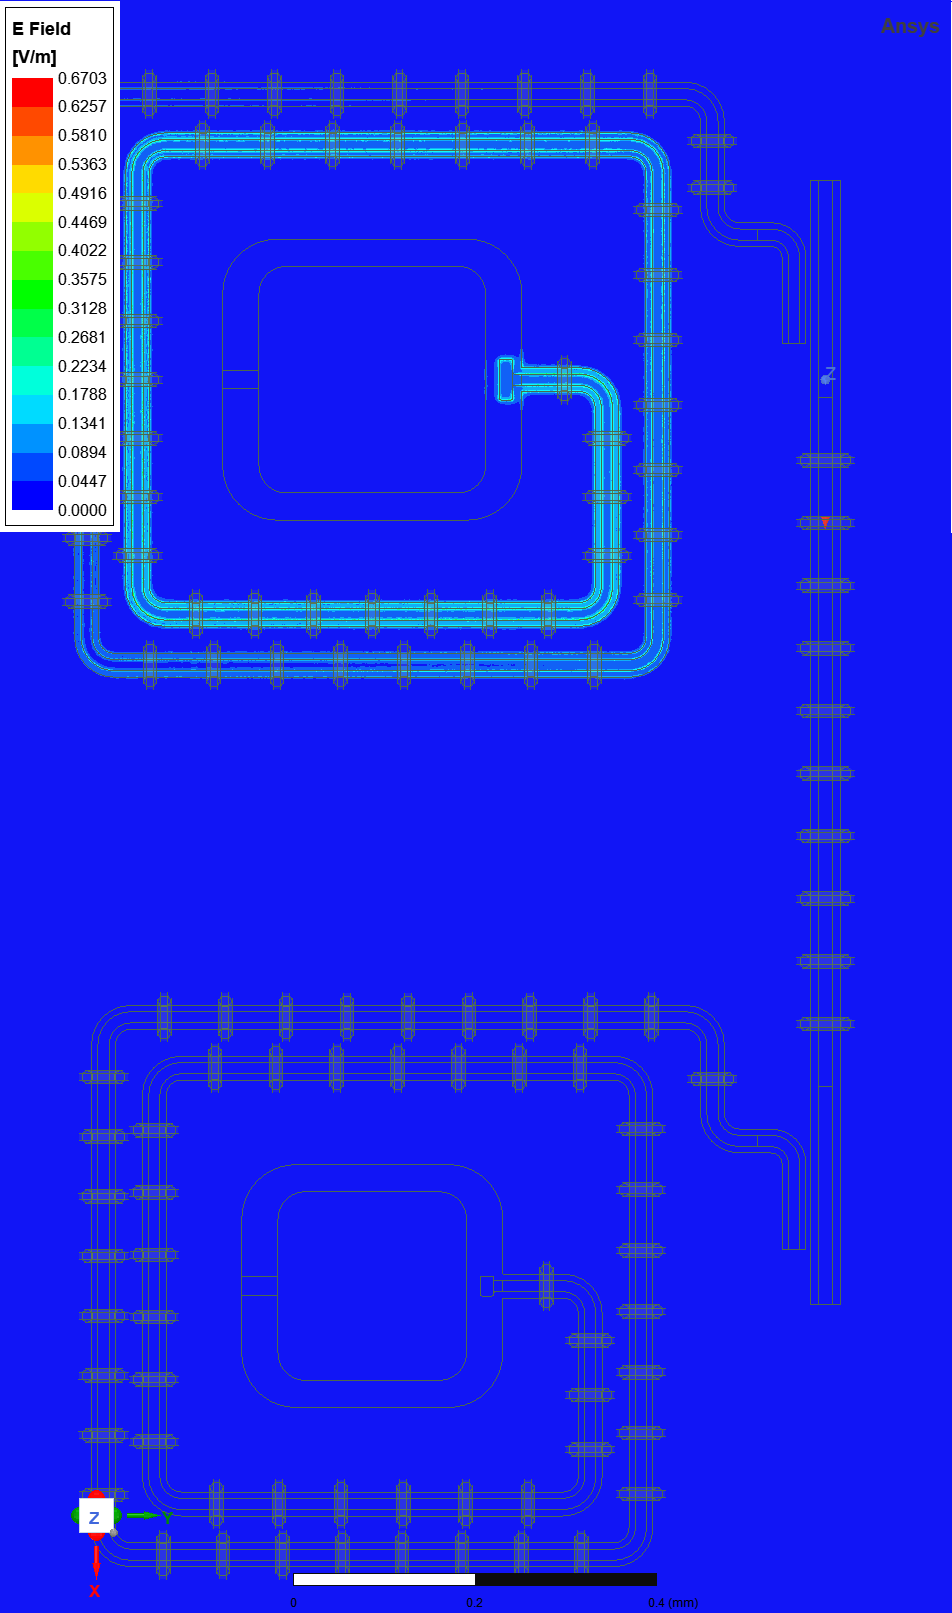

INFO 08:09PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
08:10PM 04s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


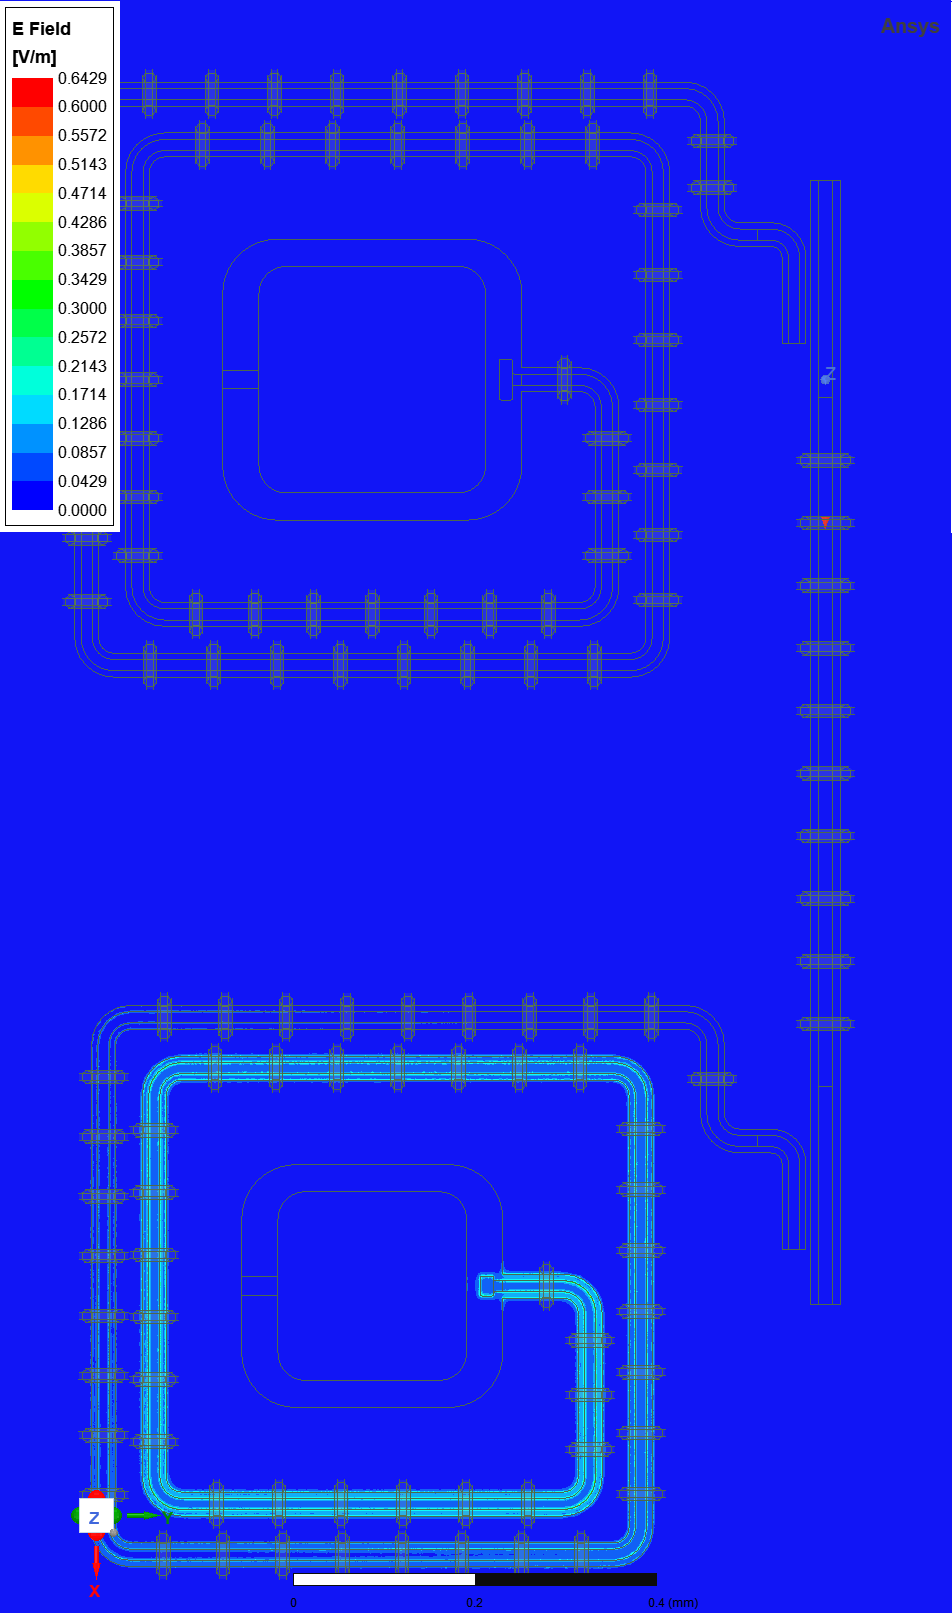

Design "all_freqs_hfss" info:
	# eigenmodes    4
	# variations    1
Design "all_freqs_hfss" info:
	# eigenmodes    4
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 3.42530171939371e-25
        energy_elec_substrate = 3.10472173926679e-25
        EPR of substrate = 90.6%

        energy_mag    = 3.41947974312473e-25
        energy_mag % of energy_elec_all  = 99.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.19 GHz   [1/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  1.385e-25 1.104e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.90%
	jj1              1.66212  (+)        0.0184093
		(U_tot_cap-U_tot_ind)/mean=-24.24%
Calculating Qdielectric_main for mode 0 (0/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9173943449494428


  _Om = pd.Series({})




  Mode 1 at 4.69 GHz   [2/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.3%  7.351e-26 5.218e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.63%
	jj1             1.10635e-05  (+)        1.5378e-07
		(U_tot_cap-U_tot_ind)/mean=98.59%
Calculating Qdielectric_main for mode 1 (1/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_1 = 0.9180260267689604


  _Om = pd.Series({})




  Mode 2 at 6.37 GHz   [3/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.2%  2.104e-25   2.1e-25

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_2j   sign s_2j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 97.50%
	jj1             0.0033874  (+)        8.68577e-05
		(U_tot_cap-U_tot_ind)/mean=-0.07%
Calculating Qdielectric_main for mode 2 (2/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_2 = 0.9064185587921147


  _Om = pd.Series({})




  Mode 3 at 6.79 GHz   [4/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.2%  1.713e-25  1.71e-25

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_3j   sign s_3j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 97.17%
	jj1             4.8882e-07  (+)        1.42486e-08
		(U_tot_cap-U_tot_ind)/mean=0.09%
Calculating Qdielectric_main for mode 3 (3/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_3 = 0.906408250604077


  options=pd.Series(get_instance_vars(self.options)),

WARNING 08:13PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 08:13PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 197.2% is > 15%.                     
Is the simulation converged? Proceed with caution



ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project39\all_freqs_hfss\2023-04-04 20-10-11.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization


ERROR 08:13PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 197.2% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions



Pm_norm=
modes
0        0.609082
1    89113.427430
2        0.798286
3     1740.565460
dtype: float64

Pm_norm idx =
     jj1
0   True
1  False
2  False
3  False
*** P (participation matrix, not normlz.)
            jj1
0  1.632079e+00
1  1.106346e-05
2  3.387101e-03
3  4.888199e-07

*** S (sign-bit matrix)
   s_jj1
0      1
1     -1
2     -1
3     -1
*** P (participation matrix, normalized.)
      0.99
   1.1e-05
    0.0034
   4.9e-07

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       106  0.00264      1.1 0.000169
   0.00264 1.65e-08 1.37e-05 2.11e-09
       1.1 1.37e-05  0.00285 8.77e-07
  0.000169 2.11e-09 8.77e-07 6.75e-11

*** Chi matrix ND (MHz) 
       112   0.0016     1.01 0.000158
    0.0016 7.33e-09 8.53e-06 1.44e-09
      1.01 8.53e-06  0.00241 7.52e-07
  0.000158 1.44e-09 7.52e-07 1.39e-10

*** Frequencies O1 PT (MHz)
0    4080.871081
1    4690.983420
2    6370.796958
3    6793.157667
dtype: float64

*** Frequencies ND (MHz)
0    407

#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,8
0,4077.95
1,4690.98
2,6370.81
3,6793.16


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0         1         2         3
Lj1                                          
8   0  1.12e+02  1.60e-03  1.01e+00  1.58e-04
    1  1.60e-03  7.33e-09  8.53e-06  1.44e-09
    2  1.01e+00  8.53e-06  2.41e-03  7.52e-07
    3  1.58e-04  1.44e-09  7.52e-07  1.39e-10

OSError: [Errno 22] Invalid argument: 'data\two_qubit_1mm_0403.csv'

08:13PM 51s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)



In [44]:
# path = r'C:\Users\slab\Desktop\Wendy-qiskit-code\Ansys_screenshoots\Simulation_0314\loop'
gap1 = 0.056
datas = pd.DataFrame()
for f1,f2 in p:
    dat = {}
    dat['guess_path'] = guess_path

    q1, cpw1, TQ1 = construct_cpw_qubit(q1, TQ1, f1, displacement = '0um', guess_path = guess_path, sim = True)
    q2, cpw2, TQ2 = construct_cpw_qubit(q2, TQ2, f2, displacement = '1mm', guess_path = guess_path, sim = True)
    TQ1.options['open_termination'] = False
    TQ2.options['open_termination'] = False
    gui.rebuild()
    gui.autoscale()

    c1.sim.run(components=components)#, open_terminations=[('Q1', 'a')])#, ('Q1', 'bus1'), ('Q1', 'bus2')])
    c1.sim.capacitance_matrix 
    
    c1.sim._get_results_from_renderer()
    c_mat = c1.sim.capacitance_matrix
    renderer_q3d.clean_active_design()
    c1  = c_mat['a_connector_pad_Q1']['pad_top_Q1']
    c2  = c_mat['a_connector_pad_Q1']['pad_top_Q2']
    c12  = c_mat['pad_top_Q1']['pad_top_Q2']

    dat['C_Q1_Q2(fF)'] = c12
    dat['C_Q1_g(fF)'] = c1
    dat['C_Q2_g(fF)'] = c2
    
    count = 0
    while count<4:
        try:
            eig_all.sim.run(name="all_freqs", components=components)#, open_terminations=[('Q1', 'a')])
        except:
            print('count')
            renderer_hfss.clean_active_design()
            count += 1
            if count>=3:
                dat['Freq'+str(i+1)+'(GHz)'] = 0
                for i in range(nmode):
                    dat['Freq_EPR'+str(i+1)+'(MHz)'] = 0
                    for j in range(i+1):
                        dat['Chi'+str(i+1)+'_'+str(j+1)+'(MHz)'] = 0
                break
        else:
            convergence = pd.read_csv('hfss_eig_f_convergence.csv')
            conv = convergence.dropna()
        
            ind = list(conv.keys())[1:]
            for i in range(nmode):
                freq = conv[ind[(i)]].values[-1]
                dat['Freq'+str(i+1)+'(GHz)'] = freq
                
            for i in range(nmode):
                    hfss.modeler._modeler.ShowWindow()
                    hfss.set_mode(i+1,'Setup')
                    hfss.plot_ansys_fields('main')
                    hfss.save_screenshot()
                    hfss.clear_fields(['main'])
                    
                    actual = r'C:\Users\slab\Desktop\Wendy-qiskit-code\f1{:.3f}_f2{:.3f}_1mm.png'.format(f1,f2)
                    os.rename(original, actual)
                    fail = True
                    i = 0
                    while fail:

                        try:
                            dest = shutil.move(actual, path)
                        except:
                            i+= 1
                            os.rename(actual,(actual+'{}'.format(i)))
                            actual = (actual+'{}'.format(i))
                        else:
                            fail = False
                    
            #Run the EPR analysis
            try:
                del eig_all.setup.junctions['jj']
            except:
                print('saddd')
            eig_all.setup.junctions.jj1 = Dict(rect='JJ_rect_Lj_Q1_rect_jj', line='JJ_Lj_Q1_rect_jj_',
                            Lj_variable='Lj1', Cj_variable='Cj1')
            eig_all.setup.sweep_variable = 'Lj1'
            eig_all.run_epr()

            #Save the EPR data
            chi = eig_all.sim.renderer.epr_quantum_analysis.get_chis().to_numpy()
            freq_EPR= eig_all.sim.renderer.epr_quantum_analysis.get_frequencies().to_numpy()[:,0]
            
            renderer_hfss.clean_active_design()
            for i in range(nmode):
                freq = freq_EPR[i]
                dat['Freq_EPR'+str(i+1)+'(MHz)'] = freq
                for j in range(i+1):
                    dat['Chi'+str(i+1)+'_'+str(j+1)+'(MHz)'] = chi[i][j]

            data = pd.DataFrame(dat, index = [0])
            datas = pd.concat([datas,data], ignore_index=True)
            break


    datas.to_csv('data\two_qubit_1mm_0403.csv')


end

In [79]:
eig_all.setup.junctions.jj1 = Dict(rect='JJ_rect_Lj_Q1_rect_jj', line='JJ_Lj_Q1_rect_jj_',
                            Lj_variable='Lj1', Cj_variable='Cj1')
eig_all.setup.junctions.jj2 = Dict(rect='JJ_rect_Lj_Q2_rect_jj', line='JJ_Lj_Q2_rect_jj_',
                            Lj_variable='Lj2', Cj_variable='Cj2')
eig_all.setup.sweep_variable = 'Lj1'
eig_all.run_epr()

AssertionError: pyEPR ProjectInfo user error found 😷:
                    Seems like for junction `jj1` you specified a rect that does not exist
                    in HFSS by the name: `JJ_rect_Lj_Q1_rect_jj` 

In [45]:
datas

,guess_path,C_Q1_Q2(fF),C_Q1_g(fF),C_Q2_g(fF),Freq1(GHz),Freq2(GHz),Freq3(GHz),Freq4(GHz),Freq_EPR1(MHz),Chi1_1(MHz),...,Chi2_2(MHz),Freq_EPR3(MHz),Chi3_1(MHz),Chi3_2(MHz),Chi3_3(MHz),Freq_EPR4(MHz),Chi4_1(MHz),Chi4_2(MHz),Chi4_3(MHz),Chi4_4(MHz)
0,data\educated_guess_0403.csv,-0.06761,-104.64603,-83.10384,4.187423,4.690985,6.371349,6.793158,4077.954851,112.468847,...,7.333755e-09,6370.808788,1.008306,0.000009,0.002407,6793.157668,0.000158,1.436234e-09,7.516518e-07,1.392365e-10


In [47]:
datas.to_csv(r'data\two_qubit_1mm_0403.csv')

In [64]:
for i in p:
    print(i)

In [78]:
eig_all.sim.setup.vars

{'Lj2': '13nH', 'Cj2': '3.3923231627469788 fF'}

# A huge loop

In [34]:
xs = np.linspace(0.65,14.5,10)
components = ['Q1','Q2','cpw_1','cpw_2','TQ1','TQ2'] 
components_all = ['Q1','Q2','cpw_1','cpw_2','TQ1','TQ2',
                  'CPW_left','CPW_right', 'CPW_mid','wb_left','wb_right']
#we are not simulating the feedline here since it contains a mode close to the qubit frequency

In [17]:
c = LOManalysis(design, "q3d")
c.sim.setup.min_passes  = 2
c.sim.setup.percent_error = 10

In [18]:
eig_all = EPRanalysis(design, 'hfss')
eig_all.sim.setup.min_passes = 5
eig_all.sim.setup.max_delta_f = 0.2

In [19]:
hfss = eig_all.sim.renderer
original = r'C:\Users\slab\Desktop\Wendy-qiskit-code\ansys.png'
path = r'C:\Users\slab\Desktop\Wendy-qiskit-code\Ansys_screenshoots\Simulation_0304'

debugging

In [29]:
# eig_all.clear
# renderer_hfss.clean_active_design()

## Save Design to GDS

In [18]:
a_gds = design.renderers.gds

In [19]:
a_gds.options

{'short_segments_to_not_fillet': 'True',
 'check_short_segments_by_scaling_fillet': '2.0',
 'gds_unit': 0.001,
 'ground_plane': 'True',
 'negative_mask': {'main': []},
 'fabricate': 'False',
 'corners': 'circular bend',
 'tolerance': '0.00001',
 'precision': '0.000000001',
 'width_LineString': '10um',
 'path_filename': '../resources/Fake_Junctions.GDS',
 'junction_pad_overlap': '5um',
 'max_points': '199',
 'cheese': {'datatype': '100',
  'shape': '0',
  'cheese_0_x': '25um',
  'cheese_0_y': '25um',
  'cheese_1_radius': '100um',
  'view_in_file': {'main': {1: True}},
  'delta_x': '100um',
  'delta_y': '100um',
  'edge_nocheese': '200um'},
 'no_cheese': {'datatype': '99',
  'buffer': '25um',
  'cap_style': '2',
  'join_style': '2',
  'view_in_file': {'main': {1: True}}},
 'bounding_box_scale_x': '1.2',
 'bounding_box_scale_y': '1.2'}

In [20]:
a_gds.options['path_filename'] = 'Customized_Components\Fake_Junctions.GDS'

In [21]:

a_gds.options['short_segments_to_not_fillet'] = 'False'
a_gds.export_to_gds('One pad design.gds')

1